#Importing Libraries

In [1]:
import os
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from keras.preprocessing.image import load_img ,img_to_array
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from nltk.translate.bleu_score import corpus_bleu

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Importing Data


In [2]:
images_directory = 'Images'
captions_path = 'captions.txt'

# importing data from captions.txt file

with open(captions_path , 'r') as f:
  #  import each line as an element of our lines list
  lines = f.readlines()
  # lowercasing the data , removing the first line because it contains just the name of the column
  lines = [line.lower() for line in lines[1:]]

lines

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a girl going into a wooden building .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a spotted dog are fighting\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a white dog with brown spots are staring at each other in the street .\n',
 '1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a little girl covered in paint sits in front of a painted rainbow 

# Data PreProcessing


In [3]:
processed_captions = []

for line in lines:
  caption = line.split(',')[1]
  # Removing all special characters (punctuation, symbols, etc..)
  caption = re.sub(r'[^\w\s]', '', caption)
  # Removing all sequences consisting of one or more digits from the string.
  caption = re.sub(r'\d+', '', caption)
  # Removing extra whitespace
  caption = re.sub(r'\s+', ' ', caption).strip()

  processed_captions.append(caption)

processed_captions[:3]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse']

In [4]:
new_lines = []
for i in range(len(processed_captions)):
  # adding the 'start' to the caption as an input and 'end' to mark the end of the caption for the LSTM model
  new_line = lines[i].split(',')[0] + '\t' + 'start '+ processed_captions[i] + ' end\n'
  new_lines.append(new_line)
new_lines[:3]

['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1000268201_693b08cb0e.jpg\tstart a girl going into a wooden building end\n',
 '1000268201_693b08cb0e.jpg\tstart a little girl climbing into a wooden playhouse end\n']

# Data Visualization

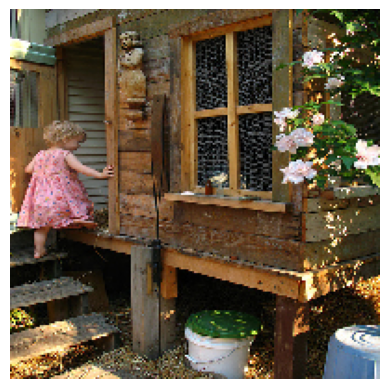

Caption: a child in a pink dress is climbing up a set of stairs in an entry way .


In [5]:
for line in lines[:3:6]:
    # Split the line to get the file name and the caption
    filename, caption = line.split(',')[0], line.split(',')[1].strip()

    # Load the image
    image_load = load_img(images_directory + '/' + filename.strip(), target_size=(199, 199))

    # Display the image
    plt.imshow(image_load)
    # Disable the axes
    plt.axis('off')
    plt.show()
    print("Caption:", caption)

In [6]:
# Create an empty set to store unique words
unique_words = set()
for sentence in processed_captions:
    words = word_tokenize(sentence)
    unique_words.update(words)

vocab_size = len(unique_words)
print('the size of the vocabulary is : ', vocab_size)

the size of the vocabulary is :  8584


# Data Splitting


In [7]:
# Storing all image IDs
ids = os.listdir(images_directory)

# Splitting the Data
train_ids , test_ids = train_test_split(ids , test_size = 0.15 , random_state =42)
val_ids , test_ids = train_test_split(test_ids , test_size = 0.1 , random_state =42)

train_id_and_captions, val_id_and_captions, test_id_and_captions = [], [], []
for line in new_lines:
    image_id, _ = line.split('\t')

    if image_id in train_ids:
        train_id_and_captions.append(line)

    elif image_id in val_ids:
        val_id_and_captions.append(line)

    elif image_id in test_ids:
        test_id_and_captions.append(line)

    else:
        print('Image ID not found!')



print('the nnumber of images in the train set is : ', len(train_id_and_captions)/ 5)
print('the nnumber of images in the test set is : ', len(test_id_and_captions)/ 5)
print('the nnumber of images in the validation set is : ', len(val_id_and_captions)/5)

the nnumber of images in the train set is :  6877.0
the nnumber of images in the test set is :  122.0
the nnumber of images in the validation set is :  1092.0


# Data Preparation For the CNN Model

In [8]:
def image_processing_for_model(image_path):
    image = load_img(image_path, target_size=(299, 299))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = tf.keras.applications.inception_v3.preprocess_input(image)
    return image

def image_features_extraction(cnn_model, image_path):
    image = image_processing_for_model(image_path)
    img_features = cnn_model.predict(image, verbose=0)
    return img_features

# Loading the pre-trained Model (InceptionV3)

In [9]:
inceptionV3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inceptionV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalizati

In [10]:
inceptionV3_model = Model(inputs=inceptionV3_model.inputs, outputs=inceptionV3_model.layers[-2].output)
inceptionV3_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

In [11]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs


for image_id in ids:

    image_path = os.path.join(images_directory, image_id)
    image_features = image_features_extraction(inceptionV3_model, image_path)

    if image_id in train_ids:
        train_image_features[image_id] = image_features.flatten()

    elif image_id in val_ids:
        val_image_features[image_id] = image_features.flatten()

    elif image_id in test_ids:
        test_image_features[image_id] = image_features.flatten()

    else:
        print('Image ID not found!')


In [12]:
tokenizer_instance = Tokenizer()
tokenizer_instance.fit_on_texts(processed_captions)

# Defining the maximum length of captions
caption_max_length = max(len(caption.split()) for caption in processed_captions) + 1

# Defining batch size
batch_size_train = 270
batch_size_val = 150

# Defining the CNN output dimension (size of feature vector from InceptionV3)
output_dim_of_cnn_model = inceptionV3_model.output_shape[1]

print("the max caption length is " , caption_max_length)
print("the Output dimension of the inceptionV3 model is  " , output_dim_of_cnn_model)

the max caption length is  34
the Output dimension of the inceptionV3 model is   2048


In [13]:
def batch_data_generator(captions, image_features, tokenizer_instance, caption_max_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer_instance.texts_to_sequences([caption_text])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=caption_max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield [np.array(X_images), np.array(X_captions)], np.array(y)

In [14]:
# Creating data generators for training and validation
train_data_generator = batch_data_generator(train_id_and_captions, train_image_features, tokenizer_instance, caption_max_length, batch_size_train)
val_data_generator = batch_data_generator(val_id_and_captions, val_image_features, tokenizer_instance, caption_max_length, batch_size_val)

# Modeling

In [15]:
def build_model(vocab_size, caption_max_length, output_dim_of_cnn_model):
    # Encoder Model
    input_image = Input(shape=(output_dim_of_cnn_model,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    # Decoder Model
    input_caption = Input(shape=(caption_max_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)

    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model

# Building the model
caption_model = build_model(vocab_size, caption_max_length, output_dim_of_cnn_model)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Features_Input (InputLayer  [(None, 2048)]               0         []                            
 )                                                                                                
                                                                                                  
 batch_normalization_94 (Ba  (None, 2048)                 8192      ['Features_Input[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 Sequence_Input (InputLayer  [(None, 34)]                 0         []                            
 )                                                                                 

In [16]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Training the Model

In [17]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_id_and_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_id_and_captions) // batch_size_val,
                        epochs=15, callbacks=[early_stopping, lr_schedule])

Epoch 1/15
127/127 [==============================] - 633s 5s/step - loss: 4.5576 - val_loss: 3.7580 - lr: 0.0055
Epoch 2/15
127/127 [==============================] - 587s 5s/step - loss: 3.3006 - lr: 0.0030
Epoch 3/15
127/127 [==============================] - 616s 5s/step - loss: 2.9081 - lr: 0.0017
Epoch 4/15
127/127 [==============================] - 589s 5s/step - loss: 2.6875 - lr: 9.0718e-04
Epoch 5/15
127/127 [==============================] - 655s 5s/step - loss: 2.5538 - lr: 4.9787e-04
Epoch 6/15
127/127 [==============================] - 574s 5s/step - loss: 2.4708 - lr: 2.7324e-04
Epoch 7/15
127/127 [==============================] - 656s 5s/step - loss: 2.4221 - lr: 1.4996e-04
Epoch 8/15
127/127 [==============================] - 621s 5s/step - loss: 2.3926 - lr: 8.2297e-05
Epoch 9/15
127/127 [==============================] - 644s 5s/step - loss: 2.3763 - lr: 4.5166e-05
Epoch 10/15
127/127 [==============================] - 613s 5s/step - loss: 2.3658 - lr: 2.4788e-05
Ep

ValueError: x and y must have same first dimension, but have shapes (15,) and (1,)

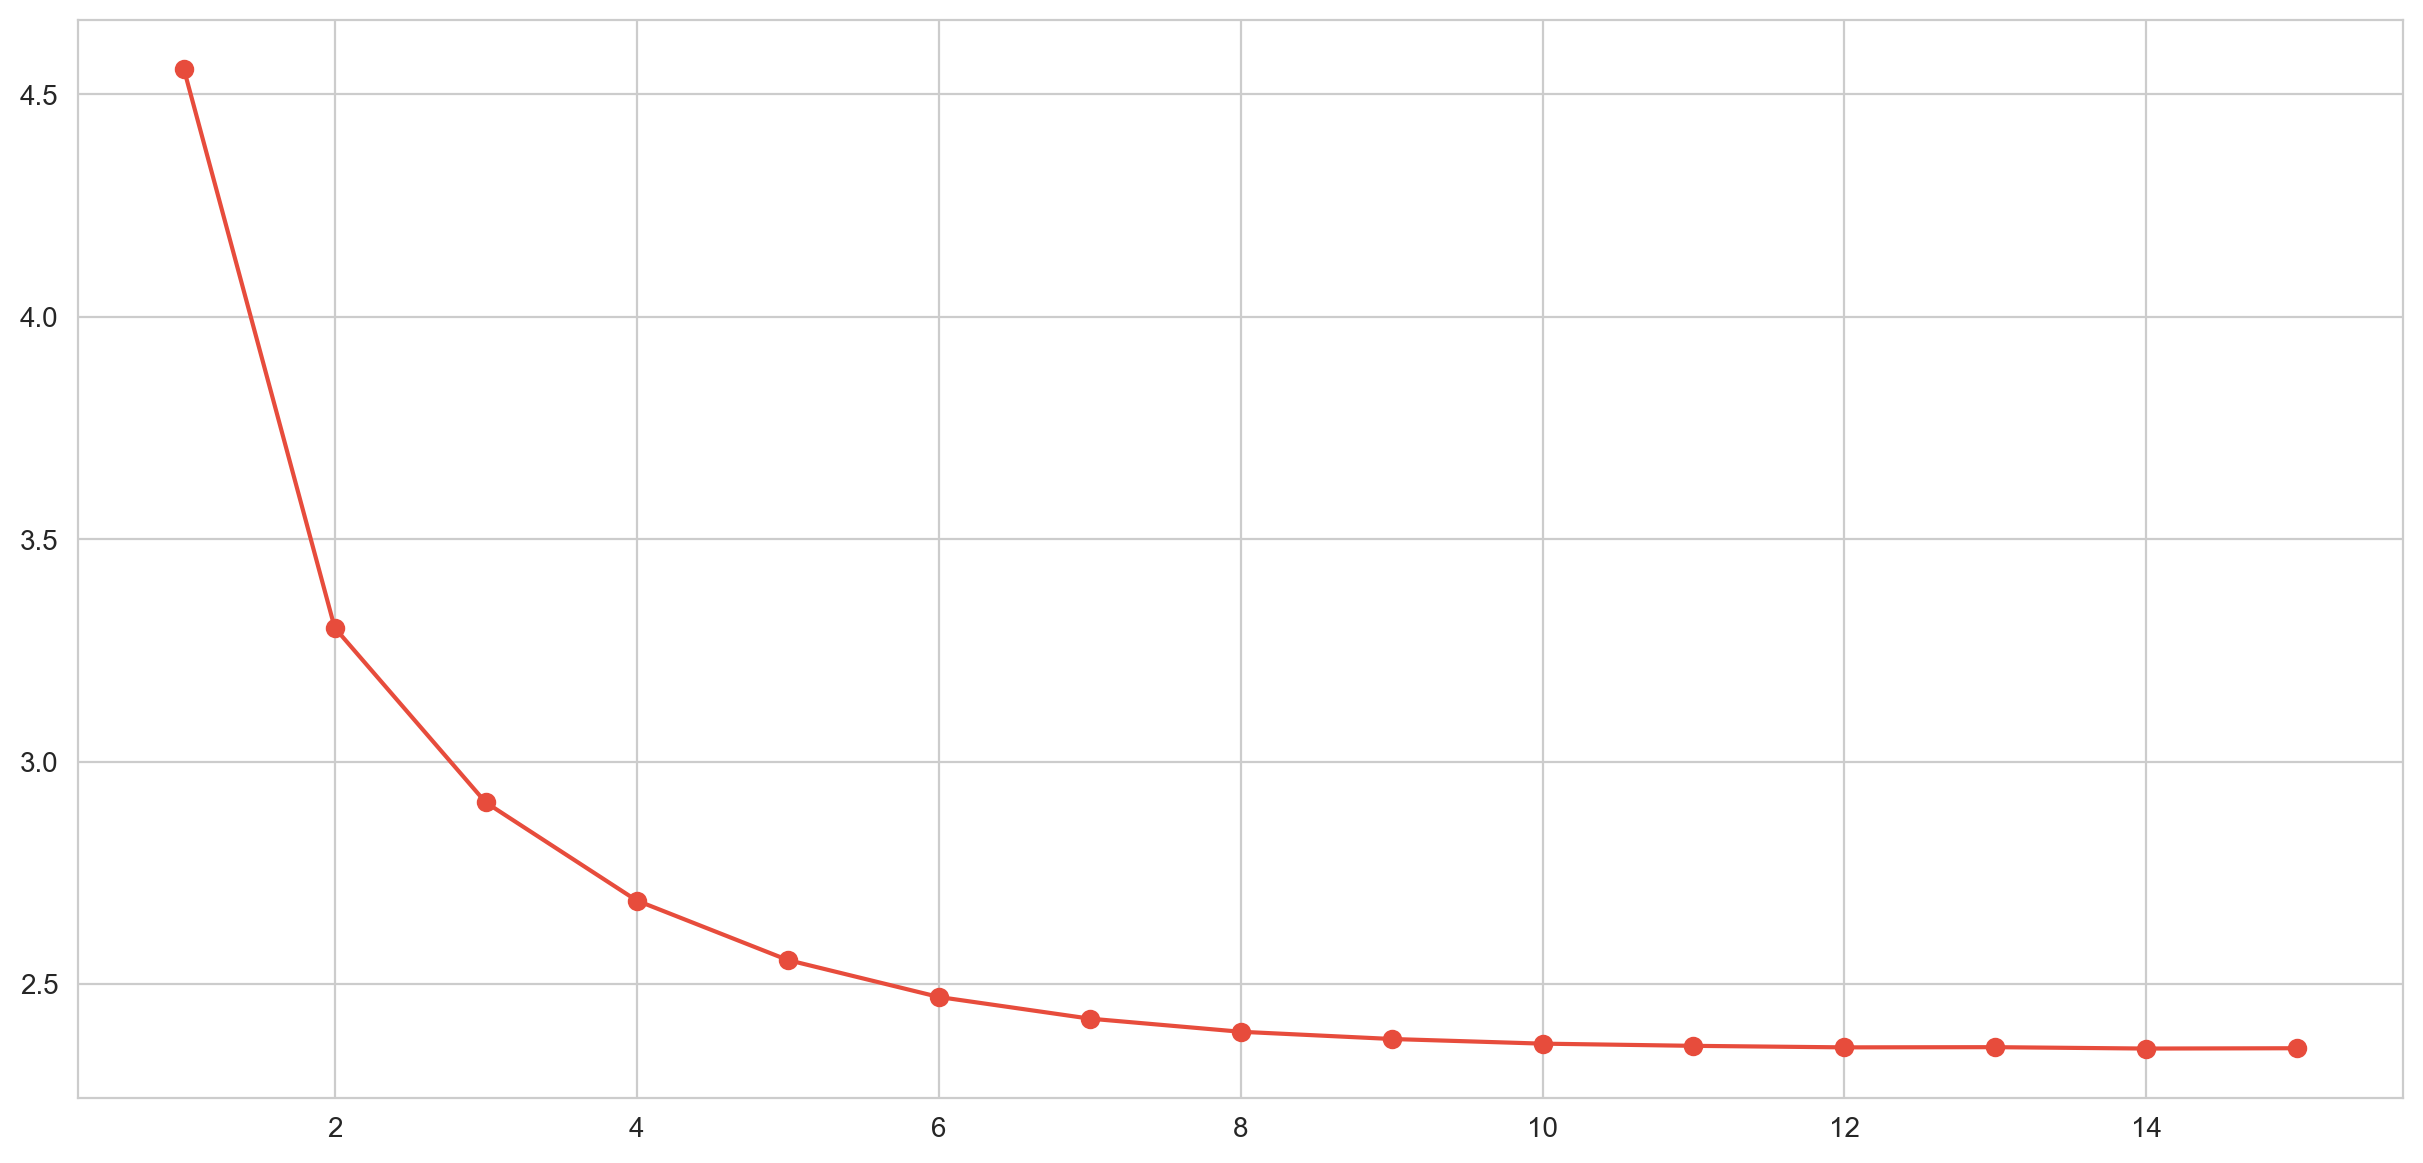

In [18]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [21]:
def greedy_generator(image_features): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(caption_max_length):
        sequence = tokenizer_instance.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=caption_max_length).reshape((1,caption_max_length))
        prediction = caption_model.predict([image_features.reshape(1,output_dim_of_cnn_model), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer_instance.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped
        if word == 'end':
            break

    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')

    return in_text

In [ ]:
# Calculates BLEU score of predictions
def BLEU_score(actual, greedy, beam_search):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    score_BS_1 = corpus_bleu(actual, beam_search, weights=(0.3, 0.3, 0.3, 0))
    score_BS_2 = corpus_bleu(actual, beam_search, weights=(0.25, 0.25, 0.25, 0.25))

    return [
        (f'BLEU-2 Greedy: {round(score_BS_2, 5)}'),
        (f'BLEU-1 Greedy: {round(score_BS_1, 5)}'),
        (f'Greedy: {greedy[0]}'),
        (f'BLEU-2 Beam Search: {round(score_greedy_2, 5)}'),
        (f'BLEU-1 Beam Search: {round(score_greedy_1, 5)}'),
        (f'Beam Search:  {beam_search[0]}')
    ]

In [23]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_id_and_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [24]:
# Generating captions
generated_captions = {}

for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap



In [ ]:
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images

    count = 1
    fig = plt.figure(figsize=(6,20))
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" end", "") for x in actual_cap] # Removing the end token

        # Generating captions
        greedy_cap = greedy_caps[filename]
        beamS_cap = beamS_generator(test_image_features[filename])

        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)), [beamS_cap]*(len(actual_cap)))

        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)